# Buffer Timespan Analysis

In [1]:
import pandas as pd

import buffer_timespan as bt

## Buffer Timespan vs Available Buffer

In [20]:
# Define root path containing experiment results 
root_path = '/Users/msharabayko/projects/srt/lib-srt-utils/_send_buffer_datasets_17.06.20_2mins/'
algo_dir = root_path + 'periodic_nak/'
df = pd.read_csv(algo_dir + '_rtt20_loss0_sendrate5_latency80/2-srt-xtransmit-stats-snd.csv', sep=",", skipinitialspace=True)
df = df[['pktSent', 'byteAvailSndBuf', 'msSndBuf']]

# Sender buffer fullness in bytes according to byteAvailSndBuf statistic
df['sndBufFullness'] = df.loc[0, 'byteAvailSndBuf'] - df['byteAvailSndBuf']
# Delete the very first row where the buffer is empty
df = df.iloc[1:]
# Packets in sender buffer according to byteAvailSndBuf statistics, 1500 bytes per packet
df['pktsSndBuf'] = df['sndBufFullness'] / 1500
# Then calculate the difference in time between packets in ms
# Statistics has been collected each 100ms, so that we divide 100 by pktSent and get the difference in ms
df['calculated_msSndBuf'] = 100 / df['pktSent']
# Then multiply by the number of packets that are currently present in buffer pktsSndBuf
# Round down to the nearest integer
df['calculated_msSndBuf'] = df['calculated_msSndBuf'] * df['pktsSndBuf']
df['calculated_msSndBuf'] = df['calculated_msSndBuf'].astype('int32')
print(df.head(10))

    pktSent  byteAvailSndBuf  msSndBuf  sndBufFullness  pktsSndBuf  \
1        47       1019001000        26           19500        13.0   
2        48       1019001000        26           19500        13.0   
3        47       1019004000        22           16500        11.0   
4        48       1018999500        28           21000        14.0   
5        48       1019002500        24           18000        12.0   
6        47       1019004000        22           16500        11.0   
7        48       1019004000        22           16500        11.0   
8        48       1019001000        26           19500        13.0   
9        47       1019001000        26           19500        13.0   
10       48       1019002500        24           18000        12.0   

    calculated_msSndBuf  
1                    27  
2                    27  
3                    23  
4                    29  
5                    25  
6                    23  
7                    22  
8                    

As a result, `msSndBuf` and calculated out of the `byteAvailSndBuf` statistic sender buffer timespan `calculated_msSndBuf` should be almost equal +-1 packet.

## Data Collection

TODO: How the data was collected
TODO: The structure of folder with data. Different periodic NAK algorithms.

It's important that `msSndBuf`, `msRcvBuf` statistics are instantenious, not moving average.

## Sender Buffer Timespan Analysis (Loss Ratio = 0%)

In [2]:
# Define root path containing experiment results 
root_path = '/Users/msharabayko/projects/srt/lib-srt-utils/_send_buffer_datasets_17.06.20_2mins/'

# Define the list of algos: tuples containing algo name and algo path inside root_path   
algos = [
    ('Periodic NAK', 'periodic_nak/')
]

# Load datasets for a specified set of algos (subfolders of root path)
df = bt.load_datasets(root_path, algos)
# print(df.head(60))

Let's filter `df` dataframe so that loss=0%, algo='Periodic NAK'; then group by rtt, sendrate and plot the min, mean, max sender buffer timespan as well as the predicted diapason.

The prediction diaposon is calculated as [RTT, RTT + 10] ms.

TODO: Use real RTT for plotting prediction.

As can be seen from the plots,
- Maximum sender buffer timespan are always higher than the prediction diaposon independently on the sending rate,
- Minimum sender buffer timespan are below the prediction diaposon and it's getting closer as the sending rate increases,
- Average sender buffer timespan are within the prediction diaposon,
- For the same values of RTT, loss ratio, and sendrate, the variability in min, mean values of sender buffer timespan is close to zero. Variability in max sender buffer timespan is much higher, however it remains at the same level across different sendrate values.

TODO: sendrate=50, RTT=40

Regarding maximum sender buffer timespan, I've checked the actual loss ratio which is equal to 0 in all the cases. So, it's not the reason.

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['rtt'] + 10


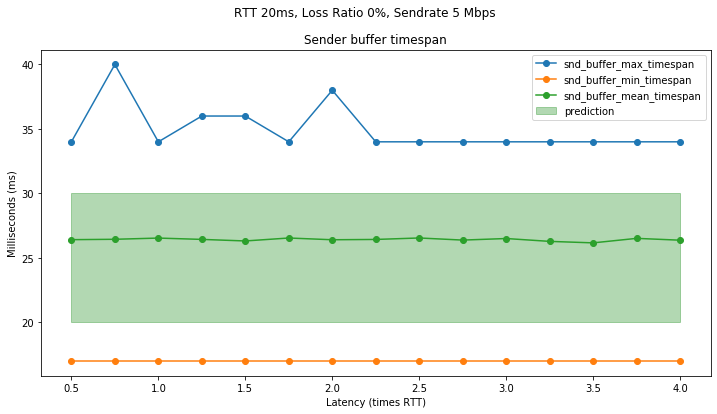

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['rtt'] + 10


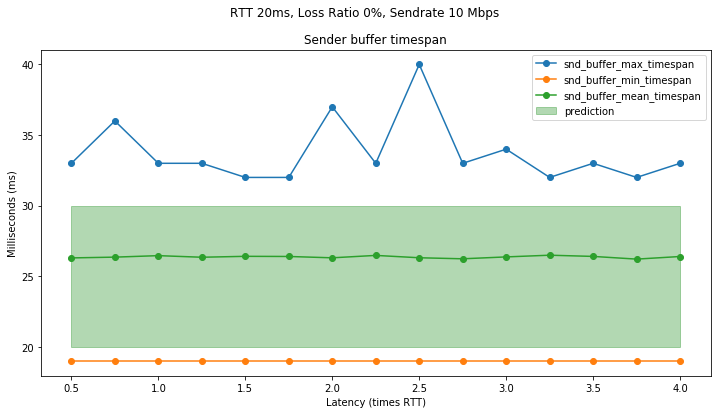

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['rtt'] + 10


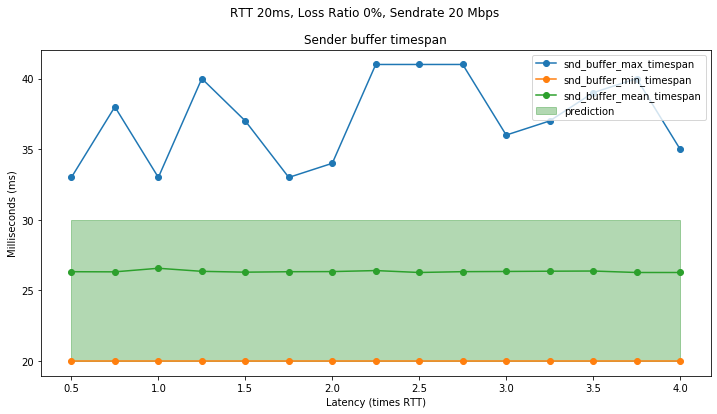

In [3]:
filtered_df = df[(df['loss']==0) & (df['algo']=='Periodic NAK')]
splitting = filtered_df.groupby(['rtt', 'sendrate'])
for group_name, group in splitting:
    bt.plot_snd_buffer_timespan(group)

Let's find 95% confidence interval for min, mean, and max sender buffer timespan for a particular RTT, sending rate, loss ratio (0% in our case) across multiple latency value (starting 0.5xRTT, ending 4xRTT in our case).

TODO: Analyse results with more data

In [4]:
conf_df = filtered_df.groupby(['rtt', 'sendrate'])[['snd_buffer_min_timespan', 'snd_buffer_max_timespan', 'snd_buffer_mean_timespan']].agg(bt.confidence_interval)
print(conf_df)

             snd_buffer_min_timespan snd_buffer_max_timespan  \
rtt sendrate                                                   
20  5                   (17.0, 17.0)            (34.0, 39.3)   
    10                  (19.0, 19.0)           (32.0, 38.95)   
    20                  (20.0, 20.0)            (33.0, 41.0)   

                              snd_buffer_mean_timespan  
rtt sendrate                                            
20  5           (26.20175585284281, 26.54009197324415)  
    10        (26.221948160535113, 26.485827759197324)  
    20          (26.26657757129725, 26.50910609857978)  


Let us plot a histogram and define percentage of data out of [RTT, RTT+10] boundaries for a particular experiment (in our case RTT=20ms, loss=0%, sendrate=5Mbps, latency=80ms). It appears to be 7.86%.

7.86


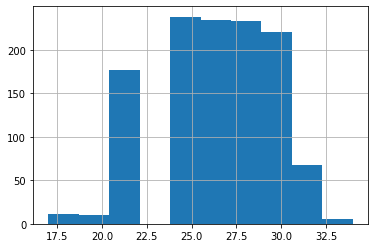

In [5]:
algo_dir = root_path + 'periodic_nak/'
single_df = pd.read_csv(algo_dir + '_rtt20_loss0_sendrate5_latency80/2-srt-xtransmit-stats-snd.csv', sep=",", skipinitialspace=True)
series = single_df['msSndBuf']
# Drop the first row where msSndBuf=0
series = series.iloc[1:]
series.hist()
rtt = 20
percentage = round((1 - series.between(rtt, rtt + 10).sum() / series.count()) * 100, 2)
print(percentage)

Let us plot the histograms and determine how much data is out of [RTT, RTT+10] boundaries across different aggregations.

TODO: Add 50Mbps, RTT=40ms

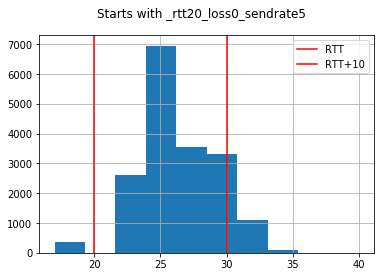

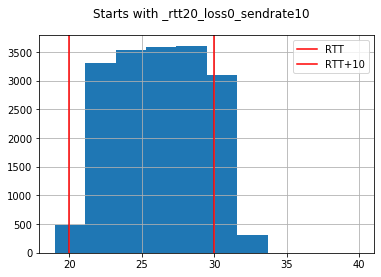

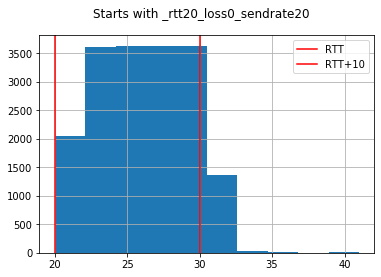

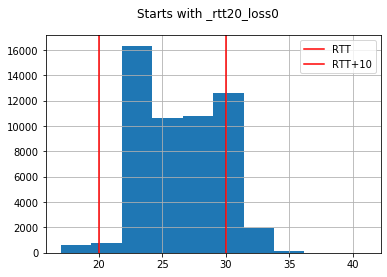

Starts with _rtt20_loss0_sendrate5: total 8.58, below RTT 1.99, higher RTT+10 6.59
Starts with _rtt20_loss0_sendrate10: total 10.62, below RTT 2.7, higher RTT+10 7.919999999999999
Starts with _rtt20_loss0_sendrate20: total 7.87, below RTT 1.37, higher RTT+10 6.5
Starts with _rtt20_loss0: total 9.02, below RTT 2.02, higher RTT+10 7.0


In [6]:
rtt = 20
sndcsv = '2-srt-xtransmit-stats-snd.csv'

starts_with_1 = '_rtt20_loss0_sendrate5'
starts_with_2 = '_rtt20_loss0_sendrate10'
starts_with_3 = '_rtt20_loss0_sendrate20'
# starts_with_1 = '_rtt20_loss0_sendrate5'
starts_with_5 = '_rtt20_loss0'
total_1, below_1, higher_1 = bt.define_percentage(algo_dir, starts_with_1, sndcsv, rtt)
total_2, below_2, higher_2  = bt.define_percentage(algo_dir, starts_with_2, sndcsv, rtt)
total_3, below_3, higher_3 = bt.define_percentage(algo_dir, starts_with_3, sndcsv, rtt)
total_5, below_5, higher_5  = bt.define_percentage(algo_dir, starts_with_5, sndcsv, rtt)
print(f'Starts with {starts_with_1}: total {total_1}, below RTT {below_1}, higher RTT+10 {higher_1}')
print(f'Starts with {starts_with_2}: total {total_2}, below RTT {below_2}, higher RTT+10 {higher_2}')
print(f'Starts with {starts_with_3}: total {total_3}, below RTT {below_3}, higher RTT+10 {higher_3}')
print(f'Starts with {starts_with_5}: total {total_5}, below RTT {below_5}, higher RTT+10 {higher_5}')